# Building a Recurrent Neural Network from Scratch

We will be using the Ham Spam Dataset to train a neural network which can classify messages as spam or ham. 

The Gameplan:
1. Data Preprocessing
2. Vocabulary
3. Dataset and DataLoader
4. Recurrent Neural Networks from Scratch
5. Training Loop
6. Testing Loop

In [1]:
# import statements
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import re
import wandb

In [2]:
wandb.init(project="PyTorch-Paper-Implementations")

wandb: Currently logged in as: mukilan. Use `wandb login --relogin` to force relogin


In [3]:
config = {"learning_rate": 1e-3,
          "batch_size": 64,
          "epochs": 40}

wandb.config = config

In [4]:
device = "mps"

## Data Preprocessing

In [5]:
# df = pd.read_csv("hamspam.csv")
df = pd.read_csv("hamspam.csv", index_col = ["Unnamed: 0"])

In [6]:
df.head()

,v1,v2,split
0,ham,"Go until jurong point, crazy.. Available only ...",train
1,ham,Ok lar... Joking wif u oni...,train
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,train
3,ham,U dun say so early hor... U c already then say...,train
4,ham,"Nah I don't think he goes to usf, he lives aro...",train


In [7]:
# df.columns = ["index", "target", "message", "split"]
df.columns = ["target", "message", "split"]

In [8]:
conversion_dict = {"ham": 0, "spam": 1}
def conversion_fn(target_val):
    return conversion_dict[target_val]

In [9]:
df["target"] = df["target"].map(lambda x: conversion_fn(x))

In [10]:
df.head()

,target,message,split
0,0,"Go until jurong point, crazy.. Available only ...",train
1,0,Ok lar... Joking wif u oni...,train
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,train
3,0,U dun say so early hor... U c already then say...,train
4,0,"Nah I don't think he goes to usf, he lives aro...",train


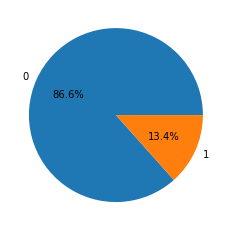

In [11]:
plt.pie(df["target"].value_counts(), labels= df["target"].unique().tolist(), autopct= '%1.1f%%')
plt.show()

In [12]:
n = df["target"].value_counts().min()

In [13]:
df =  df.groupby("target").head(n)

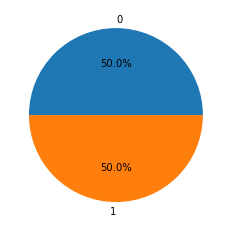

In [14]:
plt.pie(df["target"].value_counts(), labels= df["target"].unique().tolist(), autopct= '%1.1f%%')
plt.show()

In [15]:
df.head()

,target,message,split
0,0,"Go until jurong point, crazy.. Available only ...",train
1,0,Ok lar... Joking wif u oni...,train
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,train
3,0,U dun say so early hor... U c already then say...,train
4,0,"Nah I don't think he goes to usf, he lives aro...",train


In [16]:
#df = df.set_index("index")
df.to_csv("hamspam_processed.csv", index= False)

In [17]:
df = pd.read_csv("hamspam_processed.csv")
df.head()

,target,message,split
0,0,"Go until jurong point, crazy.. Available only ...",train
1,0,Ok lar... Joking wif u oni...,train
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,train
3,0,U dun say so early hor... U c already then say...,train
4,0,"Nah I don't think he goes to usf, he lives aro...",train


In [18]:
length = df["message"].map(lambda x: len(x))
print(max(length))

384


## Vocabulary

In [19]:
class Vocabulary:
    def __init__(self, messages):
        self.token_to_idx = {}
        self.idx_to_token = {}
        self.messages = messages
        self.add_token("<UNK>")
        self.special_char = re.compile(r'[;\\/,!.:*?\"<>|&\']')
        for message in messages:
            for word in message.split(" "):
                word = re.sub(self.special_char, " ", word)
                word = word.lower()
                self.add_token(word)
        
    def add_token(self,token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
            
    def vectorize(self, message):
        one_hot = torch.zeros(100,1, len(self.token_to_idx))
        for num, word in enumerate(message.split(" ")):
            word = re.sub(self.special_char, " ", word)
            word = word.lower()
            if num >= 100:
                break
            elif word in self.token_to_idx:
                one_hot[num][0][self.token_to_idx[word]] = 1
            else:
                word = "<UNK>"
                one_hot[num][0][self.token_to_idx[word]] = 1
        return one_hot
    
    def len_token_idx(self):
        return len(self.token_to_idx)
    

## Dataset and DataLoader

In [20]:
class SpamDataset(Dataset):
    def __init__(self, df, messages_col, target_col, transform = None):
        self.df = df
        self.transform = transform
        
        self.messages = self.df[messages_col]
        self.target = self.df[target_col]
        
        self.vocab = Vocabulary(self.messages)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        message = self.messages[index]
        target = self.target[index]
        
        if self.transform is not None:
            message = self.transform(message)
            
        vectorized_message = torch.tensor(self.vocab.vectorize(message))
        vectorized_target = torch.tensor(target)
        
        return vectorized_message, vectorized_target
    
    def len_token_idx(self):
        return self.vocab.len_token_idx()

In [21]:
train_dataset = SpamDataset(df, "message", "target")
train_dataloader = DataLoader(train_dataset, batch_size= config["batch_size"], shuffle=True)

## Recurrent Neural Networks from Scratch

In [22]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size ,output_size)
        self.softmax = nn.LogSoftmax(dim = 0)
        
    def forward(self, input_message, hidden):
        combined = torch.cat((input_message, hidden), 0)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(self.hidden_size)

In [23]:
input_size = train_dataset.len_token_idx()
hidden_size = train_dataset.len_token_idx()
output_size = 1

model = RNN(input_size, hidden_size, output_size).to(device)
print(model)

wandb.watch(model)

RNN(
  (i2h): Linear(in_features=11720, out_features=5860, bias=True)
  (h2o): Linear(in_features=5860, out_features=1, bias=True)
  (softmax): LogSoftmax(dim=0)
)


[]

In [24]:
loss_fn = nn.BCELoss()

In [25]:
optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"])

## Training Loop

In [26]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.float()
        y = y.to(device)
        pred = torch.empty((0), dtype = torch.float32).to(device)
        # Compute prediction and loss
        for sentence in X:
            hidden = model.initHidden().to(device)
            for word_vector in sentence[1]:
                output, hidden = model(word_vector, hidden)
            pred = torch.cat((pred, output), 0)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 1 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            wandb.log({"loss" : loss})

In [27]:
for t in range(config["epochs"]):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)

Epoch 1
-------------------------------


/var/folders/qp/h29sqr1j4qlg8r6r10m9q9xh0000gn/T/ipykernel_6593/28697797.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectorized_message = torch.tensor(self.vocab.vectorize(message))


Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
Epoch 21
-------------------------------
Epoch 22
-------------------------------
Epoch 23
-------------------------------
Epoch 24
-------------------------------
Epoch 25
-------------------------------
Epoch 26
---------------

## Testing

In [28]:
def test_model(input_text):
    vectorized_input = train_dataset.vocab.vectorize(input_text)
    vectorized_input.to("cpu")
    model.to("cpu")
    hidden = model.initHidden().to("cpu")
    for word_vector in vectorized_input[1]:
        word_vector.to("cpu")
        output, hidden = model(word_vector, hidden)
    return output

In [29]:
input_text = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
output = test_model(input_text)
print(output)

tensor([0.], grad_fn=<LogSoftmaxBackward0>)
